# Exercise 8: Reading a mesh from file.

Michael R. Johansen: michael.ruben.johansen@nmbu.no
Fabian H. Heflo: fabian.halmrast.heflo@nmbu.no

## Task 1: Read the data.

In [1]:
import numpy as np
import meshio
from abc import ABC, abstractmethod


class Mesh:
    def __init__(self,file='data/simple.msh'):
        msh = meshio.read(file)
        self.type = msh.cells[1].type
        self.points = msh.points
        self.cells = msh.cells

mesh = Mesh()
print(mesh.cells[1].data[222],mesh.type)


[110 234 128] triangle


## Task 2: Finding the neighbours of each cell in the mesh

**Optimizations implemented**

In this exercise we have identified different types of optimizations that can be implemented in the code. These are:
- Search space reduction: we can reduce the search space by knowing that if a cell has a neighbour, then the neighbour also has the cell as a neighbour. This means that we only need to search for the neighbours of a cell in the cells that have a higher id than the cell itself. This can halve the search space.
- Early stopping: we can stop the search for neighbours of a cell if we have found all the neighbours. This can be done by checking if the number of neighbours is equal to the number of vertices of the cell. If this is the case, then we have found all the neighbours of the cell and we can stop the search. 
- Set operations: we can use set operations to find the neighbours of a cell. This can be done by findind the intersection between the vertices of the cell and the vertices of the other cells. If the intersection has two elements, then the other cell is a neighbour of the cell.

**Defining the support classes**

We first need to define some support classes that will be used in the implementation of the mesh class.
These are:
- Cell: a class that contains the information of a cell in the mesh. It has three methods: the constructor, a dunder repr method, and a dunder call method. 
1.  The constructor takes as input the cell id, the cell type, and the cell vertices. 
2.  The dunder repr method returns a string representation of the cell. 
3.  The dunder call method calculates the neighbours of the cell using set operations.
- Line: a subclass of the Cell class that contains the information of a line in the mesh.
- Triangle: a subclass of the Cell class that contains the information of a triangle in the mesh.


In [160]:
def show_process(func):
    """Decorator to print the start and end of a function, used for debugging"""
    def wrapper(*args,**kwargs):
        print(f"Start {func.__name__}")
        res = func(*args,**kwargs)
        print(f"End {func.__name__}")
        return res
    return wrapper

class Cell(ABC):
    def __init__(self,*args,points,id):
        """Converts the array of indexes into a set"""
        self.id = id
        self.points = [points[i] for i in args]
        self.indexes = set(args)
        self.neighbours = list()

    def append(self,cell):
        if len(cell.neighbours) < len(cell.indexes):
            self.neighbours.append(cell.id)
            cell.neighbours.append(self.id)

    def __repr__(self):
        return f"{self.__class__.__name__}({self.id})"
    
class Line(Cell):
    def __init__(self,*args,points,id=None): 
        super().__init__(*args,points=points,id=id) 
        assert len(args) == 2
    def __call__(self,cell):
        """Same as store_neighbors in the original exercise"""
        if cell.__class__.__name__ == "Line" and len(cell.indexes.intersection(self.indexes)) == 1:
            self.append(cell)
        elif cell.__class__.__name__ == "Triangle" and len(cell.indexes.intersection(self.indexes)) == 2:
            self.append(cell)

class Triangle(Cell):
    def __init__(self,*args,points,id=None):
        super().__init__(*args,points=points, id=id)
        assert len(args) == 3
    def __call__(self,cell):
        """Same as store_neighbors in the original exercise"""
        if len(cell.indexes.intersection(self.indexes)) == 2:
            self.append(cell)


**Defining the mesh class**

The mesh class contains the information of the mesh. It has the following methods:

- The constructor: it takes as input the mesh file name and the mesh type. It reads the mesh file and stores the information in the information in two lists. self.points and self.cells. 
1. The self.points list contains the coordinates of each point in the mesh. 
2. The self.cells list contains the information of each cell in the mesh. The cell information is stored in a cell object.
- The cell factory. It takes as input the raw msh.cells variable and returns a list of cell objects.
- find_neighbors. it iterates over the cells in the mesh and calculates the neighbours of each cell using the dunder call method of the cell class.

In [161]:
class Mesh:
    def __init__(self,file="data/simple.msh"):
        """Reads a mesh file and converts it into a list of line and triangle objects"""
        msh = meshio.read(file)
        self.points = msh.points
        self.cell_factory(msh.cells)

    @abstractmethod 
    def cell_factory(self,cells):
        """Converts the mesh cells into a list of line and triangle objects"""
        types = {'line': Line, 'triangle': Triangle}
        self.cells = []; id = 0
        for cellblock in cells:
            "Extend is used to add the elements of a list to another list"
            for cell in cellblock.data:
                self.cells.append(types[cellblock.type](*cell,points=self.points, id=id))
                id += 1

    def find_neighbours(self):
        """Finds the neighbours of each cell"""
        for cell in self.cells:
            "We dont need to check the cells before the current cell, as they have already been checked"
            for other in self.cells[self.cells.index(cell)+1:]: 
                cell(other)
                if len(cell.neighbours) == 3: break
        for cell in self.cells:
            cell.neighbours = list(cell.neighbours)
        return self
    
mesh = Mesh()

**Calculating the neighbours of each cell**

Here we are calling the find_neighbors method of the mesh class to calculate the neighbours of each cell in the mesh.
We then quickly test that no cell has more than 3 neighbours.
Lastly we return the neighbours of the cells with id: 4, 189 and 222

In [162]:
mesh.find_neighbours()  
%timeit -n 10 -r 5 mesh.find_neighbours()

for cell in mesh.cells:
    assert len(cell.neighbours) <= 3

print(mesh.cells[4].neighbours, '\n', mesh.cells[189].neighbours, '\n', mesh.cells[222].neighbours)

33.2 ms ± 2.97 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
[3, 5, 189] 
 [4, 218, 308] 
 [200, 224, 427]


## Displaying Mesh 

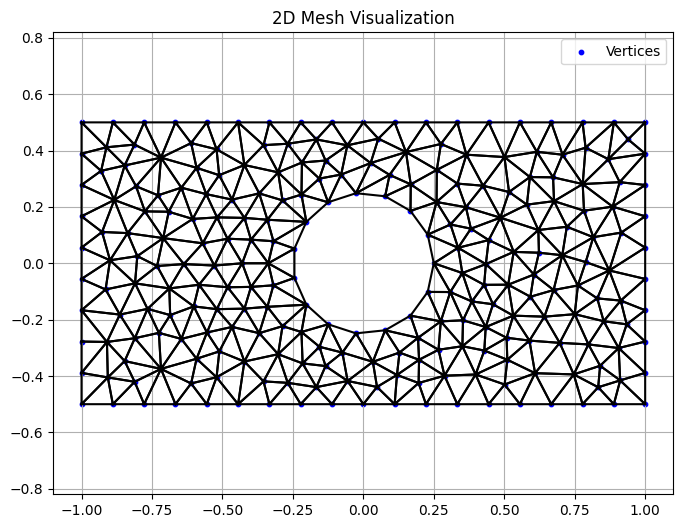

In [163]:
import matplotlib.pyplot as plt

# Load the 2D mesh using meshio
mesh = meshio.read("data/simple.msh")  # Replace with your 2D mesh file path

# Extract vertices and faces from the mesh
vertices = mesh.points
faces = mesh.cells_dict["triangle"]  # Assuming triangular mesh
# Plotting the mesh
plt.figure(figsize=(8, 6))

# Plot vertices
plt.scatter(vertices[:, 0], vertices[:, 1], color='blue', s=10, label='Vertices')

# Plot faces (connect vertices)
for face in faces:
    v0, v1, v2 = face
    plt.plot([vertices[v0][0], vertices[v1][0], vertices[v2][0], vertices[v0][0]],
             [vertices[v0][1], vertices[v1][1], vertices[v2][1], vertices[v0][1]],
             color='black')

plt.title('2D Mesh Visualization')
plt.legend()
plt.grid()
plt.axis('equal')  # Set equal aspect ratio
plt.show()